# Nonlinear agent, 4 static obstacles, Time-Varying Constraints

### Nonlinear dynamics

$\dot{X} = \frac{r}{2} \cos(\Theta) (\omega _{l} + \omega _{r})$ $\qquad$ ($X$: x-position)
    
$\dot{Y} = \frac{r}{2} \sin(\Theta) (\omega _{l} + \omega _{r})$ $\qquad\ $ ($Y$: y-position)
 
$\dot{\Theta} = \frac{r}{L} (\omega _{r} - \omega _{l})$ $\qquad\qquad\ $ ($\Theta$: difference between angular speeds of wheels)

### State vector

$z = (X, Y, \Theta)^{\intercal}$

### Input vector

$u = (\omega _{l}, \omega _{r})^{\intercal}$

where $\omega _{l}$ and $\omega _{r}$ are angular speeds of left and right wheel respectively.

### Constants

$r$: radius of wheels

$L$: distance between wheels

## Matlab code

In [1]:
clear
yalmip clear
close all
warning off

### Define Dynamics

In [2]:
r = 0.03;
L = 0.1;
f = @(x, u) [(r/2)*cos(x(3))*(u(1)+u(2)); (r/2)*sin(x(3))*(u(1)+u(2)); (r/L)*(u(2)-u(1))]; % state equation
g = @(x, u) x(1:2); % output equation

### Discretization

In [3]:
Ts = 1; % sampling time

The state-update equation must take three inputs (current state, current input and the agent object) and return one output (successor state vector):

In [4]:
state_eq = @(x, u, ~) x+Ts*f(x, u);

The output equation must take three inputs (current state, current input and the agent object) and return the x-y position vector:

In [5]:
output_eq = @(x, u, ~) g(x, u);

### The agent

First we create an agent with 3 states, 2 inputs and 2 outputs:

In [6]:
N = 30;     % prediction horizon
agent = moantool.NonlinearAgent('nx', 3, 'nu', 2, 'ny', 2, 'PredictionHorizon', N)

agent = 

  NonlinearAgent with properties:

           StateEq: []
          OutputEq: []
                nx: 3
                nu: 2
                ny: 2
                 N: 30
                 X: [3x1x31 moantool.AgentSignal]
                 U: [2x1x30 moantool.AgentSignal]
                 Y: [2x1x30 moantool.AgentSignal]
              Size: [2x1x30 moantool.AgentSignal]
    ConstraintsFun: []
      ObjectiveFun: []


Then we set nonlinear agent dynamics:

In [7]:
agent.StateEq = state_eq;
agent.OutputEq = output_eq

agent = 

  NonlinearAgent with properties:

           StateEq: @(x,u,~)x+Ts*f(x,u)
          OutputEq: @(x,u,~)g(x,u)
                nx: 3
                nu: 2
                ny: 2
                 N: 30
                 X: [3x1x31 moantool.AgentSignal]
                 U: [2x1x30 moantool.AgentSignal]
                 Y: [2x1x30 moantool.AgentSignal]
              Size: [2x1x30 moantool.AgentSignal]
    ConstraintsFun: []
      ObjectiveFun: []


Input constraints, reference and penalties:

In [8]:
agent.U.Min = [-40; -40];
agent.U.Max = [40; 40];
agent.U.Reference = zeros(agent.nu, 1);
agent.U.Penalty = 1e-3*eye(agent.nu); % Slightly penalize control inputs to keep them small

Output constraints (as '`parameter`' because we will use time-varying constraints), reference and penalties:

In [9]:
agent.Y.Min = 'parameter'; 
agent.Y.Max = 'parameter';
agent.Y.Penalty = eye(agent.ny); % Fixed penalty on position tracking
agent.Y.Reference = 'parameter'; % The position reference will be time-varying

we have no state constraints nor reference:

In [10]:
agent.X.Min = -Inf(agent.nx, 1);
agent.X.Max = Inf(agent.nx, 1);
agent.X.Reference = zeros(agent.nx, 1); % can be anything
agent.X.Penalty = zeros(agent.nx);

Since we will be plotting the agent as a planar object, we set its width and height to one:

In [11]:
agent.Size.Value = [1; 1];

Beacuse of nonlinear dynaics, we will use only time-varying constraints, therefore variable `MixedInteger` is set false:

In [12]:
MixedInteger = false;

### The Obstacle

Then we create 4 static obstacles, set their visibility and size:

In [13]:
obstacles = moantool.Obstacle(agent, 4);
for i = 1:length(obstacles)
    obstacles(i).Visible.Value = 0;     % all obstacles are not visible to the agent
    obstacles(i).Size.Value = [3; 2];   % all have fixed size
end

And for each obstacle we set its position:

In [14]:
obstacles(1).Position.Value = [0; 10];
obstacles(2).Position.Value = [10; 0];
obstacles(3).Position.Value = [0; -10];
obstacles(4).Position.Value = [-10; 0];

and minimal separation gap between the agent and the obstacle:

In [15]:
minsep = agent.Size.Value;

### The Planner

Next, we create a planner which will be responsible for optimizing the control inputs for the agent:

In [16]:
planner = moantool.Planner(agent, obstacles, 'MinSeparation', minsep,...
    'solver', 'fmincon', 'MixedInteger', MixedInteger)

planner = 

  Planner with properties:

      Parameters: [1x1 struct]
    MixedInteger: 0


### The Simulator

To make closed-loop simulation, we create Simulator:

In [17]:
psim = moantool.Simulator(planner)

psim = 

  Simulator with properties:

       Results: [1x1 struct]
    Parameters: [1x1 struct]


Before starting the simulation, we need to define number of simulation steps, intial point and values for time-varying parameters:

In [18]:
Nsim = 350; % number of simulation steps
x0 = [0; 0; 0]; % initial point
psim.Parameters.Agent.Y.Reference = psim.circularTrajectory(Nsim, 'Radius', 10, 'Loops', 2);

When done, we can run the simulation:

In [19]:
psim.run(x0, Nsim);

To plot the results, launch:

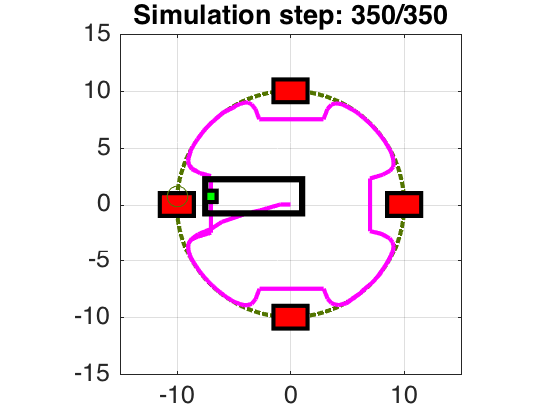

In [20]:
psim.plot('Axis', [-15 15 -15 15], 'Reference', true, 'Trail', true,...
        'Predictions', true, 'PredSteps', 10, 'Constraints', true);

where '`Axis`' sets dimension of both axis, '`Reference`' enable/disable showing the reference, '`Predictions`' enable/disable showing ptredicted positions of the agent, '`PredSteps`' defines number of displayed predictions, '`Trail`' enable/disable showing realized trajectory of agent and '`Constraints`' enable/disable showing the constraints.

## Notes & hints

**Hint**: use the `Simulator/circularTrajectory` helper to automatically create a trajectory over `Nsim` steps which follows specified circular trajectory:

In [1]:
Nsim = 20;
r = moantool.Simulator.circularTrajectory(Nsim, 'Radius', 5, 'Loops', 1)

r =

  Columns 1 through 7

   -5.0000   -4.7553   -4.0451   -2.9389   -1.5451    0.0000    1.5451
   -0.0000   -1.5451   -2.9389   -4.0451   -4.7553   -5.0000   -4.7553

  Columns 8 through 14

    2.9389    4.0451    4.7553    5.0000    4.7553    4.0451    2.9389
   -4.0451   -2.9389   -1.5451         0    1.5451    2.9389    4.0451

  Columns 15 through 21

    1.5451    0.0000   -1.5451   -2.9389   -4.0451   -4.7553   -5.0000
    4.7553    5.0000    4.7553    4.0451    2.9389    1.5451    0.0000
